In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.utils as image
import os
import datetime
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

## Library

## Read in the data

In [7]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/train',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/test',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/val',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

Found 1296 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 124 files belonging to 2 classes.


Find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [3]:
class_names = train_set.class_names
print(class_names)

['A', 'S']


Here are the random nine images from the training dataset:

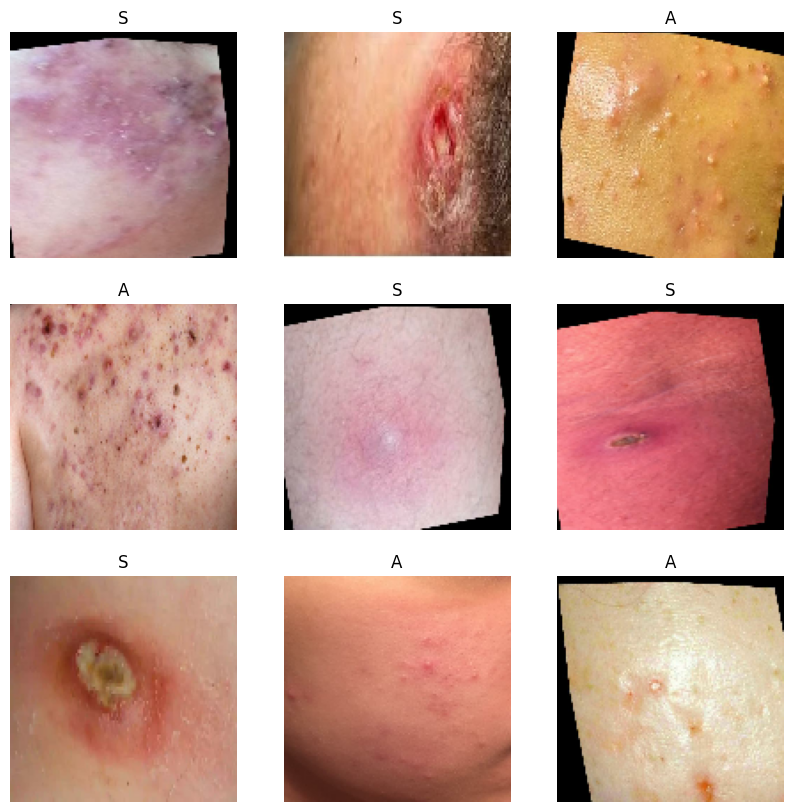

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

According to tf.keras.utils.image_dataset_from_directory document, labels should be sorted according to the alphanumeric order of the image file paths so: 

* Class A : 0

* Class S : 1

In [5]:
#The labels should match the smple images showed above
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1])>

Check number of images for each class.

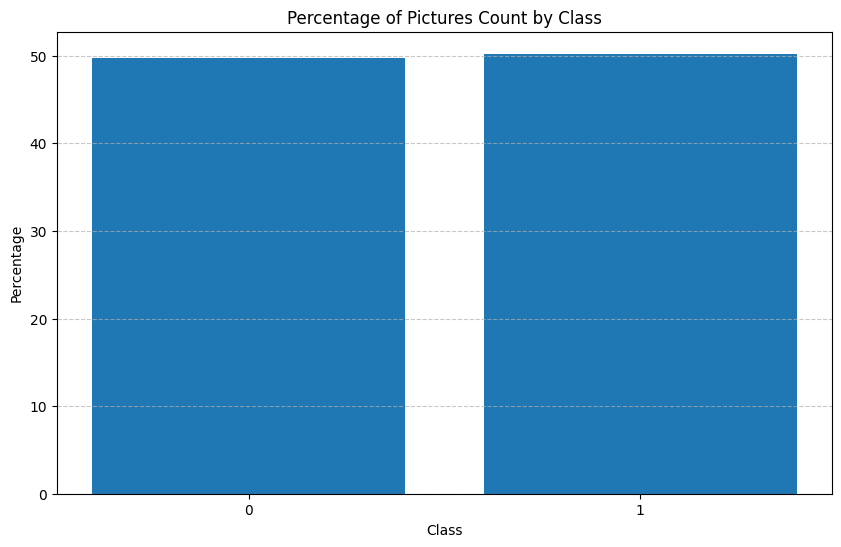

In [6]:
class_count_train = {}
for images, labels in train_set:
    for label in labels.numpy():
        if label not in class_count_train :
            class_count_train [label] = 1
        else:
            class_count_train [label] += 1

class_counts_df_train = {}

for images, labels in train_set:
    for label in labels.numpy():
        class_count_train[label] = class_count_train.get(label, 0) + 1
    
class_counts_df_train = pd.DataFrame(class_count_train .items(), columns=["Class", "Pictures Count"])

total_pictures = class_counts_df_train['Pictures Count'].sum()

# Calculate the percentage for each class and add it as a new column
class_counts_df_train['Percentage'] = (class_counts_df_train['Pictures Count'] / total_pictures) * 100

plt.figure(figsize=(10, 6))
plt.bar(class_counts_df_train['Class'], class_counts_df_train['Percentage'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Percentage of Pictures Count by Class')
plt.xticks(class_counts_df_train['Class'])  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

This is a batch of 32 images of shape 128x128x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


To enhance the performance

* train.cache(): Caches the elements of the dataset, which can improve the training speed by avoiding redundant data loading.

* .shuffle(1000): Shuffles the elements of the dataset with a buffer size of 1000. This randomizes the order of the data, which is beneficial during training.

* .prefetch(buffer_size=AUTOTUNE): Prefetches elements from the dataset to overlap the data loading and model execution. The buffer_size is set to the AUTOTUNE constant, allowing TensorFlow to determine an optimal value for parallelism.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
num_classes

2

## Modeling

Function to plot the learning curve:

In [10]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

## Baseline Model

### cnn1

In [ ]:
log_dir = "logs/fit/" + "cnn1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn1_checkpoint", save_best_only=True)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)), # Standardize the data, the pixel values are now in `[0,1]`
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs= 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

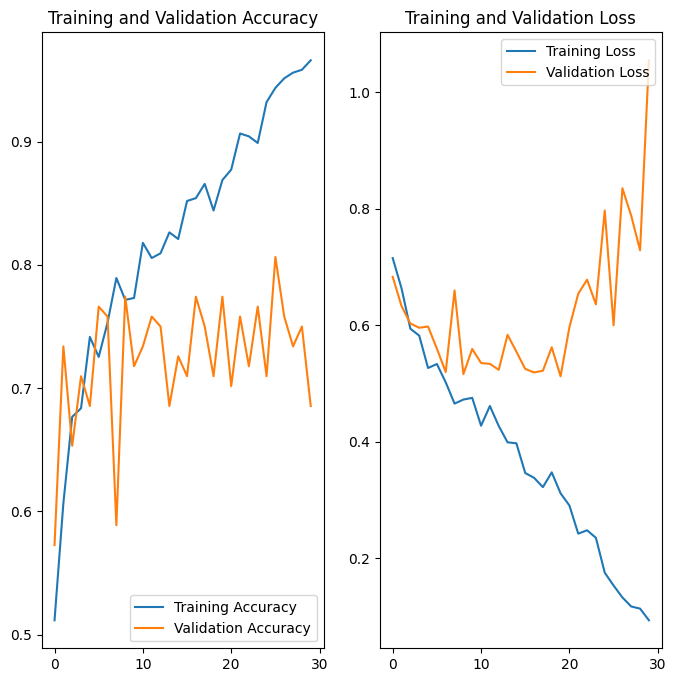

In [25]:
plot_training_history(history)

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

In [ ]:
model.save("Models\cnn1_model", save_format="tf")

### cnn2

In [ ]:
log_dir = "logs/fit/" + "cnn2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn2_checkpoint", save_best_only=True)

tf.random.set_seed(420)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

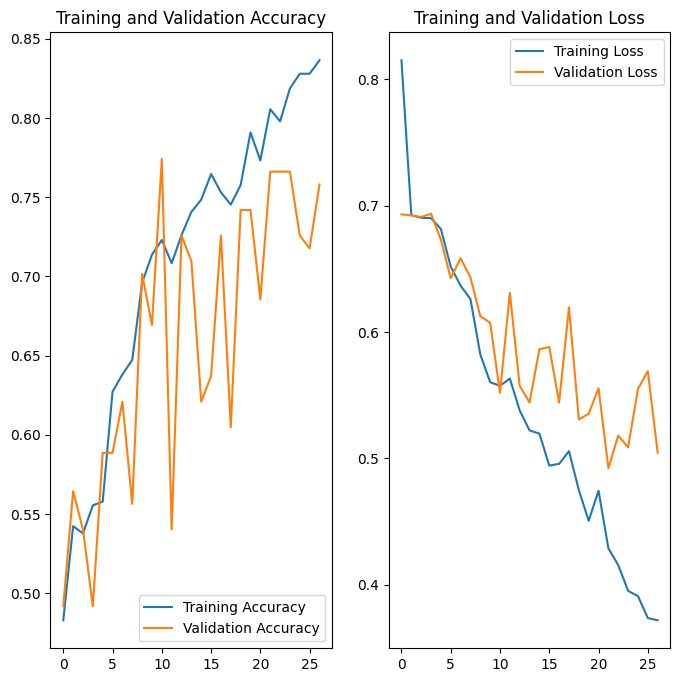

In [15]:
plot_training_history(history)

### cnn3

In [ ]:
log_dir = "logs/fit/" + "cnn3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn3_checkpoint", save_best_only=True)

tf.random.set_seed(420)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

In [12]:
model.save("Models\cnn3_model", save_format="tf")

INFO:tensorflow:Assets written to: cnn3_model\assets


INFO:tensorflow:Assets written to: cnn3_model\assets


In [13]:
model = tf.keras.models.load_model("Models\cnn3_model")

Continues traing cnn3 for a few more epochs. 

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  initial_epoch = 19,
  epochs=50, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

### cnn4

In [ ]:
log_dir = "logs/fit/" + "cnn4"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn4_checkpoint", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 30)

tf.random.set_seed(420)
model = Sequential([
     layers.Rescaling(1./255, input_shape=(128, 128, 3)),
     layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
     layers.BatchNormalization(),
     layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.2),
     layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.3),
     layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.4),
     layers.Flatten(),
     layers.Dense(128, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.5),
     layers.Dense(num_classes, name="outputs")
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback_patience20 , checkpoint_callback]
)

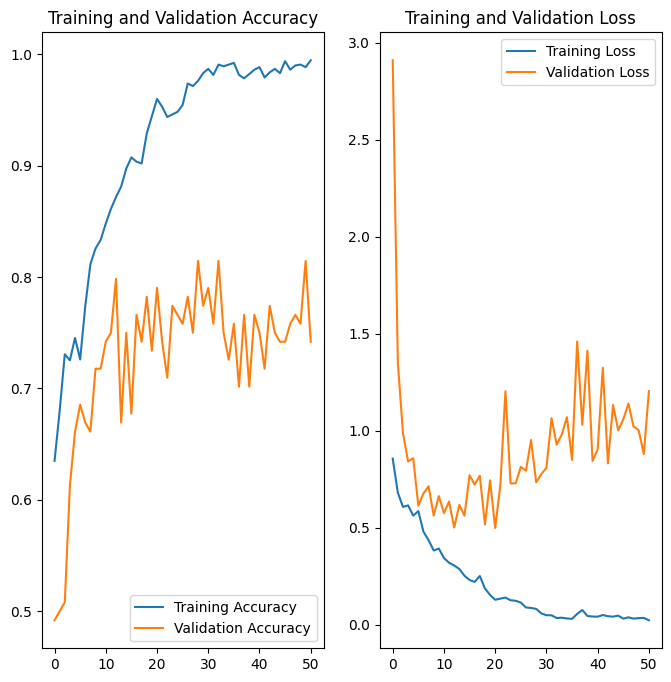

In [12]:
plot_training_history(history)

In [13]:
max(model.history.history["val_accuracy"])

0.8145161271095276

In [14]:
model.save("Models\cnn4_model", save_format="tf")

INFO:tensorflow:Assets written to: cnn4_model\assets


INFO:tensorflow:Assets written to: cnn4_model\assets


## Xception

I load an Xception model, pretrained on ImageNet, and exclude the top of the network by setting include_top=False(This excludes the global average pooling layer and the dense output layer).

All of the trials use transfer learning with following:

Freeze the base model layers train for 5 epochs at 0.1 learning rate then unfreeze the layers for fine-tuning with early stoppping at 0.0001 learning rate.

Optimizar: SGD

Batch Size : 32

In [11]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [12]:
train_ds = (
    train_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    test_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [14]:
base_model_xception = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_xception.output)

#Dense Output Layer
output = tf.keras.layers.Dense(num_classes, name="outputs")(avg)

model = tf.keras.Model(inputs = base_model_xception.input, outputs = output)

Freeze the weights of the pretrained layers at the beginning of training.

In [15]:
for layer in base_model_xception.layers:
    layer.trainable = False

In [ ]:
log_dir = "logs/fit/" + "xception1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception1_checkpoint", save_best_only=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epoch = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epoch, 
  callbacks=[tensorboard_callback, checkpoint_callback]
)

Fine-Tuning

The top layers are now pretty well trained, and I am ready to unfreeze some of the base model’s top layers, then continue training. I will unfreeze layers 116 and above (that’s the start of residual unit 13 out of 14) and use a much lower learning rate

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model_xception.layers[idx].name:22}", end="")
    print()

In [18]:
for layer in base_model_xception.layers[116:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [ ]:
log_dir = "logs/fit/" + "xception1_finetuning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception1_finetuning_checkpoint", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 30)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tune_epoch = 100
total_epoch =  initial_epoch + fine_tune_epoch

history_finetuning = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epoch, 
  initial_epoch=history.epoch[-1],
  callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback_patience20]
)


In [26]:
max(model.history.history["val_accuracy"])

0.8548387289047241

In [27]:
model.save("Models/xception1_finetuning_model", save_format="tf")

INFO:tensorflow:Assets written to: xception1_finetuning_model\assets


INFO:tensorflow:Assets written to: xception1_finetuning_model\assets


## YOLO

In [ ]:
%pip install ultralytics

In [1]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

Ultralytics YOLOv8.1.2 🚀 Python-3.11.4 torch-2.0.1+cpu CPU (13th Gen Intel Core(TM) i9-13900H)
Setup complete ✅ (20 CPUs, 31.6 GB RAM, 396.3/451.4 GB disk)


In [ ]:

# Load a model
model = YOLO('Models\yolo_pretrained\yolov8x-cls.pt') # load a pretrained model (recommended for training)

# Train the model
model.train(data='Data\Test1.v1i.folder', 
            epochs=100, batch = 32, 
            imgsz = 128, 
            verbose = True, 
            patience = 20, 
            save = True,
            seed = 420, 
            val = True, 
            plots = True)

In [3]:
yolov8_result = pd.read_csv("runs/classify/train/results.csv")
yolov8_result.sort_values(by="  metrics/accuracy_top1", ascending=False)

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
67,68,0.01867,0.93548,1,0.38345,0.000247,0.000247,0.000247
83,84,0.01196,0.92742,1,0.39005,0.000134,0.000134,0.000134
75,76,0.01307,0.92742,1,0.39294,0.000191,0.000191,0.000191
87,88,0.01297,0.92742,1,0.39176,0.000106,0.000106,0.000106
84,85,0.00636,0.91935,1,0.39078,0.000127,0.000127,0.000127
...,...,...,...,...,...,...,...,...
5,6,0.17675,0.83871,1,0.46120,0.000686,0.000686,0.000686
4,5,0.22721,0.83871,1,0.47829,0.000693,0.000693,0.000693
13,14,0.10905,0.83871,1,0.46030,0.000629,0.000629,0.000629
30,31,0.04524,0.83871,1,0.44921,0.000509,0.000509,0.000509


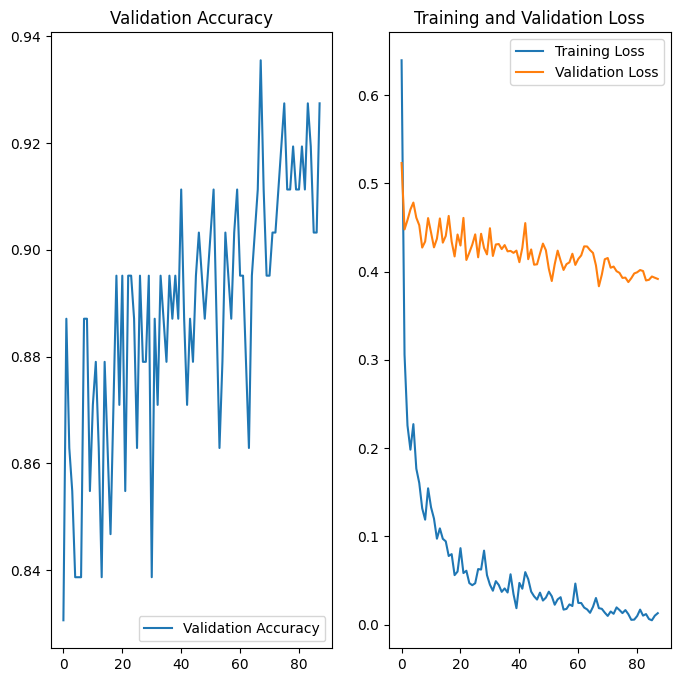

In [4]:
val_acc = yolov8_result["  metrics/accuracy_top1"]

loss = yolov8_result["             train/loss"]
val_loss = yolov8_result["               val/loss"]

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [6]:
#If want to load the model and resume training

#model = YOLO('runs/classify/train\weights/last.pt')  